## Import 및 Device 설정
- 라이브러리 임포트
- GPU 사용 여부 체크

In [1]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 이미지 전처리
- 관측 이미지 리사이즈
- RGB 이미지 그레이스케일로 변경

In [2]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

## 환경 클래스
- **초기화**
    - **no_operation:** 초기 reset 후 no-op 액션을 몇 번 수행하여 초기 상태를 다양하게 함
    - **skip_frames:** 한 번의 step에서 여러 프레임을 스킵하여 계산량을 줄이고 더 추상화된 동작을 하게 함
    - **stack_frames:** 마지막 n개 프레임을 쌓아(스택) 관측으로 사용한다. 이렇게 하면 단일 이미지만으로는 파악하기 어려운 속도/이동 정보 등을 시간적 연속성으로 얻을 수 있음
- **reset:** 환경 리셋 후 no-op 수행, 관측 이미지 전처리 후 초기 스택 상태 생성
- **step:** skip_frames 동안 같은 액션을 반복, reward 합산, 최종 관측 이미지 stack에 추가

In [3]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

## A2C 모델
- 환경이 연속/복잡한 상태일때 유리

In [4]:
class ActorCriticNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self._n_features = 32 * 9 * 9
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(self._n_features, 256),
            nn.ReLU(),
        )
        self.policy_head = nn.Linear(256, out_channels)
        self.value_head = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self._n_features)
        x = self.fc(x)
        logits = self.policy_head(x)
        value = self.value_head(x)
        return logits, value

## ReplayMemory 클래스
- **Transition:** 강화학습 에이전트의 경험을 저장하기 위한 데이터 구조
- **init:** capacity 변수를 사용해 리플레이 메모리에 저장할 최대 경험수 정의
- **push:** Transition을 리플레이 메모리에 추가
- **sample:** batch_size만큼 Transition 랜덤 샘플링

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## A2C

In [6]:
class A2C:
    def __init__(self, action_space, batch_size=256, gamma=0.99, lr=0.0007):
        self._n_observation = 4
        self._n_actions = action_space.n
        self.action_space = action_space
        self.batch_size = batch_size
        self.gamma = gamma
        self.network = ActorCriticNet(self._n_observation, self._n_actions).to(device)
        self.network = nn.DataParallel(self.network, device_ids=[0,1,2,3])  # Multi-GPU 설정
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        self._memory = ReplayMemory(10000)
        self._evaluate_loss = []

    def select_action(self, state, evaluation_phase=False):
        with torch.no_grad():
            logits, value = self.network(state)
            probs = F.softmax(logits, dim=1)
            if evaluation_phase:
                # 평가 시엔 argmax로 선택
                action = probs.argmax(dim=1, keepdim=True)
            else:
                # 학습 시엔 확률적으로 샘플링
                dist = torch.distributions.Categorical(probs)
                action = dist.sample().view(1, 1)
            return action

    def train(self):
        if len(self._memory) < self.batch_size:
            return

        transitions = self._memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # 필터링
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        logits, values = self.network(state_batch)
        _, next_values = self.network(non_final_next_states)

        # next value 계산
        next_values_full = torch.zeros(self.batch_size, device=device)
        next_values_full[non_final_mask] = next_values.view(-1)

        # Advantage 계산
        advantages = (reward_batch + self.gamma * next_values_full) - values.view(-1)
        advantages = advantages.detach()

        # 정책 손실 계산
        probs = F.softmax(logits, dim=1)
        dist = torch.distributions.Categorical(probs)
        log_probs = dist.log_prob(action_batch.view(-1))
        policy_loss = -(log_probs * advantages).mean()

        # 가치 손실 계산
        value_loss = F.mse_loss(values.view(-1), reward_batch + self.gamma * next_values_full)

        # 엔트로피 보너스 (옵션)
        entropy = dist.entropy().mean()
        entropy_coef = 0.01
        loss = policy_loss + 0.5 * value_loss - entropy_coef * entropy

        # 백프로파게이션 및 최적화
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self._evaluate_loss.append(loss.item())

    def get_loss(self):
        return self._evaluate_loss

    def save_model(self, i):
        torch.save(self.network.state_dict(), f'./a2c/model_weights_{i}.pth')

    def load_model(self, i):
        self.network.load_state_dict(torch.load(f'./a2c/model_weights_{i}.pth', map_location=device))



## 학습 코드

In [7]:
rewards_per_episode = []
episode_duration = []
average_episode_loss = []

episodes = 1000
# C = 5  # A2C는 타겟 네트워크 사용하지 않으므로 이 변수는 불필요하지만 그냥 놔둬도 문제는 없다.

env = gym.make('CarRacing-v2', lap_complete_percent=0.95, continuous=False)
n_actions = env.action_space
agent = A2C(n_actions)

for episode in range(1, episodes + 1):

    if episode % 10 == 0:
        print(f"{episode} episodes done")

    env = gym.make('CarRacing-v2', continuous=False)
    env = CarEnvironment(env)

    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    episode_total_reward = 0

    for t in count():
        action = agent.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        episode_total_reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
            print("Finished the lap successfully!")
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        agent._memory.push(state, action, next_state, reward)
        state = next_state

        agent.train()

        if done:
            if len(agent._memory) >= 128:
                episode_duration.append(t + 1)
                rewards_per_episode.append(episode_total_reward)
                ll = agent.get_loss()
                average_episode_loss.append(sum(ll) / len(ll))
            break

    if episode % 100 == 0:
        agent.save_model(episode)
        with open('./a2c/statistics.pkl', 'wb') as f:
            pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

agent.save_model(episodes)
with open('./a2c/statistics.pkl', 'wb') as f:
    pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

Finished the lap successfully!
10 episodes done
Finished the lap successfully!
20 episodes done
30 episodes done
Finished the lap successfully!
40 episodes done
50 episodes done
60 episodes done
70 episodes done
80 episodes done
90 episodes done
100 episodes done
110 episodes done
Finished the lap successfully!
120 episodes done
130 episodes done
140 episodes done
150 episodes done
160 episodes done
170 episodes done
180 episodes done
Finished the lap successfully!
190 episodes done
Finished the lap successfully!
Finished the lap successfully!
200 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
210 episodes done
Finished the lap successfully!
Finished the lap successfully!
220 episodes done
230 episodes done
240 episodes done
250 episodes done
260 episodes done
Finished the lap successfully!
Finished the lap successfully!
270 episodes done
280 episodes done
290 episodes done
Finished the lap successfully!
300 episodes done
310 

## 통계 시각화 함수
- 데이터 시각화
- 이미지 저장
- 분석

In [7]:
def plot_statistics(x, y, title, x_axis, y_axis):
    plt.plot(x, y)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_")}.png')  # 공백 대신 밑줄 사용
    plt.show()
     

## 평가 코드

/tmp/ipykernel_2963504/2102854799.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.network.load_state_dict(torch.load(f'./a2c/model_weights_{i}.pth', map_location=d

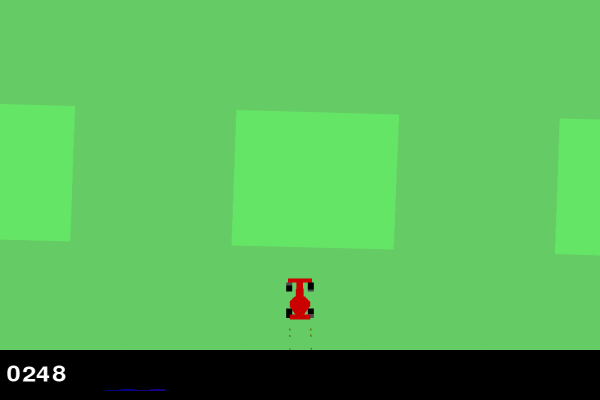

241.79692832763263


In [8]:
#환경 생성 및 불러오기
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = A2C(n_actions)
agent.load_model(1000)

#변수 초기화
frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

#렌더링을 위한 함수 및 디스플레이 핸들
from PIL import Image as PILImage
def render2img(_img): return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    #현재 스텝의 프레임 이미지를 받아 업데이트 및 저장
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    #상태, 액션 선택 및 변환
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True) #평가 모드
    discrete_action = a.item() % 5
    #환경 스텝 적용 및 결과 관측
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    #상태 및 보상 업데이트
    s = s_prime
    ret += r
    done = terminated or truncated
    #에피소드 종료 시 처리
    if terminated:
      print(terminated)

#총 점수 업데이트 및 출력
scores += ret
print(scores)


def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    #비디오 파일 이름 설정
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP80')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    #프레임을 비디오에 추가
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

## 통계 데이터 시각화 및 평가 결과 비디오에 저장

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


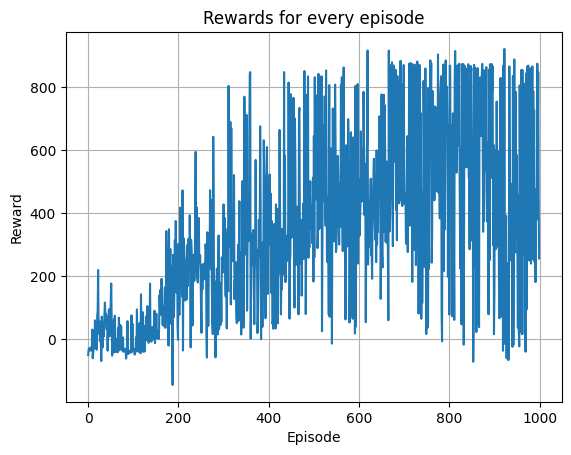

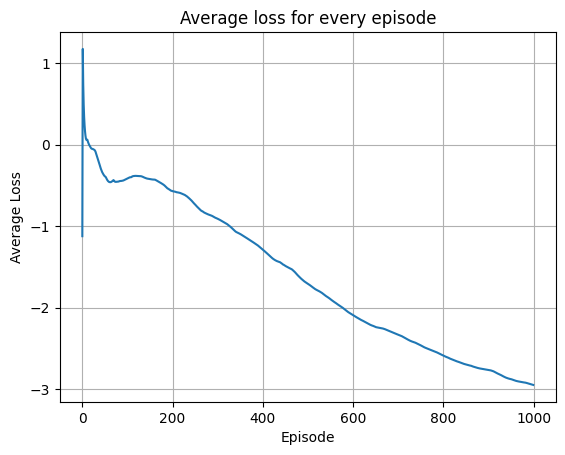

In [9]:
#비디오 애니메이션 생성
animate(frames, None)

#통계 데이터 로드
with open('./a2c/statistics.pkl', 'rb') as f:
    data_tuple = pickle.load(f)

episode_duration, rewards_per_episode, average_episode_loss = data_tuple

x = [k for k in range(1000)]

rewards_per_episode = [tensor.cpu() if tensor.is_cuda else tensor for tensor in rewards_per_episode]

#통계 데이터 시각화
plot_statistics(x, rewards_per_episode, "Rewards for every episode", "Episode", "Reward")
plot_statistics(x, average_episode_loss, "Average loss for every episode", "Episode", "Average Loss")